# setup dataset

In [1]:
# import stuff
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torch.utils.data as data
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function

In [2]:
# import dataset
from utils.dataset import VOCDataset, DatasetTransform, make_datapath_list, Anno_xml2list, od_collate_fn

In [3]:
## meta settings
import pretrainedmodels
model_name = 'resnet18' # choose from any resnets
DATASET = "VOC"
retina = False # for trying retinanets
fpn = False # try for fpns
scale = 1

## make data.Dataset for training

In [5]:
if not DATASET == "COCO":
    # load files
    # set your VOCdevkit path here.
    vocpath = "../VOCdevkit/VOC2007"
    train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(vocpath)

    vocpath = "../VOCdevkit/VOC2012"
    train_img_list2, train_anno_list2, _, _ = make_datapath_list(vocpath)

    train_img_list.extend(train_img_list2)
    train_anno_list.extend(train_anno_list2)

    print("trainlist: ", len(train_img_list))
    print("vallist: ", len(val_img_list))

    # make Dataset
    voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
                   'bottle', 'bus', 'car', 'cat', 'chair',
                   'cow', 'diningtable', 'dog', 'horse',
                   'motorbike', 'person', 'pottedplant',
                   'sheep', 'sofa', 'train', 'tvmonitor']

    if scale == 1:
        input_size = 300  # set image size
    else:
        input_size = 512

    ## DatasetTransform
    transform = DatasetTransform(input_size)
    transform_anno = Anno_xml2list(voc_classes)

    # Dataloader
    train_dataset = VOCDataset(train_img_list, train_anno_list, phase = "train", transform=transform, transform_anno = transform_anno)
    val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DatasetTransform(
        input_size), transform_anno=Anno_xml2list(voc_classes))

else:
    from dataset.coco import COCODetection
    import torch.utils.data as data
    from utils.dataset import VOCDataset, COCODatasetTransform, make_datapath_list, Anno_xml2list, od_collate_fn

    if scale == 1:
        input_size = 300  # 画像のinputサイズを300×300にする
    else:
        input_size = 512

    ## DatasetTransform
    transform = COCODatasetTransform(input_size)
    train_dataset = COCODetection("../data/coco/", image_set="train2014", phase="train", transform=transform)
    val_dataset = COCODetection("../data/coco/", image_set="val2014", phase="val", transform=transform)

batch_size = int(32/scale)

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn, num_workers=8)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn, num_workers=8)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

trainlist:  16551
vallist:  4952


In [6]:
# confirm operation
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].shape)  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数

torch.Size([32, 3, 300, 300])
32
torch.Size([1, 5])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


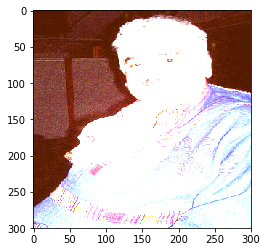

In [38]:
# show image
img = images.numpy()[0]
plt.imshow(img.transpose(1,2,0))

In [43]:
np.mean(np.asarray([target[:,2],target[:,0]]), axis=0)

array([0.3413598 , 0.50708216], dtype=float32)

In [44]:
# show targets
target = np.asarray(targets[0])
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4]]).T
center

array([[ 0.3413598 ,  0.60899997, 11.        ],
       [ 0.50708216,  0.508     , 14.        ]], dtype=float32)

In [45]:
img -= np.min(img)

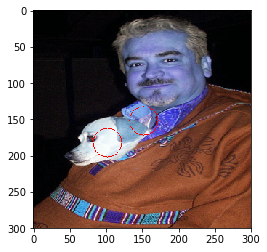

In [46]:
# Let's see if the center is encoded right

img2 = cv2.imread("../VOCdevkit/VOC2007/JPEGImages/000001.jpg")
img2 = cv2.resize(img2, (300,300))

# plot stuff centers
for c in center:
    img2 = cv2.circle(img2, (int(c[0]*input_size), int(c[1]*input_size)), 20, (255, 0, 0))

plt.imshow(img2/255)


The center is encoded right!

Now, we make the heatmaps so that centernet can train to predict centers.

# define Centernet model and test

In [ ]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

# create backbone.
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[:-2])

In [ ]:
class centernet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(centernet, self).__init__()
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue
        self.outr = nn.Conv2d(256, n_classes*4, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.base_model(x)
        
        # Add positional info        
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

In [ ]:
if not DATASET == "COCO":
    num_class = 21
else:
    num_class = 81

# test if net works
net = centernet(num_class)
print(torch.rand([1,3,input_size,input_size]).size())
outc, outr = net(torch.rand([1,3,input_size,input_size]))
print(outc.size())

# set up optimizers

In [ ]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from utils.ssd_model import MultiBoxLoss
# define loss
criterion = MultiBoxLoss(jaccard_thresh=0.5,neg_pos=3, device=device, half=HALF)
# optim
import torch.optim as optim
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=1e-3)

In [ ]:
# while the original efficientdet uses cosine annealining lr scheduling, we utilize epoch-based lr decreasing for simplicity.
def get_current_lr(epoch): 
    if DATASET == "COCO":
        reduce = [120, 180]
        lr = 1e-3
    else:
        reduce = [120,180]
        lr = 1e-3
        
    for i,lr_decay_epoch in enumerate(reduce):
        if epoch >= lr_decay_epoch:
            lr *= 0.1
    return lr

def adjust_learning_rate(optimizer, epoch):
    lr = get_current_lr(epoch)
    print("lr is:", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# set up train and eval scripts

In [ ]:
# train script. nothing special..
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("used device:", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):
        
        adjust_learning_rate(optimizer, epoch)
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('(train)')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('(val)')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # リストの各要素のテンソルをGPUへ
                if HALF:
                    images = images.half()
                    targets = [ann.half() for ann in targets]
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)
                    #print(outputs[0].type())
                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('Iter {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()
                        # filter inf..
                        if not loss.item() == float("inf"):
                            epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    else:
                        if not loss.item() == float("inf"):
                            epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log/"+DATASET+"_"+backbone+"_" + str(300*scale) +"log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 5 == 0):
            if useBiFPN:
                word="BiFPN"
            else:
                word="FPN"
            torch.save(net.state_dict(), 'weights/'+DATASET+"_"+backbone+"_" + str(300*scale) + "_" + word + "_" + 
                       str(epoch+1) + '.pth')


In [ ]:
if DATASET == "COCO":
    num_epochs = 200
else:
    num_epochs = 200
    
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)